<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-and-parsing-input-data" data-toc-modified-id="Reading-and-parsing-input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading and parsing input data</a></span></li><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#Feature-generation" data-toc-modified-id="Feature-generation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature generation</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification</a></span></li><li><span><a href="#Test-data" data-toc-modified-id="Test-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test data</a></span></li></ul></div>

This code is derived from the notebook from the original De Neuter et al study: 
https://github.com/bittremieux/TCR-Classifier

The biggest difference is the addition of an alpha-only, and a paired alpha-beta variant

In [1]:
# imports
import collections
import itertools
import random
import math
import string
import os
from pathlib import Path

import IPython
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pyteomics import electrochem, mass, parser
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
from sklearn.model_selection import cross_val_predict

%matplotlib inline

pd.options.display.max_rows = 12
pd.options.display.precision = 3
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['xtick.labelsize'] = 6

## Reading and parsing input data

Data used by this notebook can be found in:
https://github.com/viragbioinfo/IMMREP_2022_TCRSpecificity

In [2]:
def split_rows(df, column_name, split_str):
    """
    Duplicates and splits rows in a pandas `DataFrame` based on the given split substring.
    
    Rows that contain the given split substring in the given column will be duplicated with each new row
    containing part of the split column in the corresponding column.
    
    Args:
        - df: The pandas `DataFrame` in which rows will be duplicated and split.
        - column_name: The name of the column in the given `DataFrame` on which rows will be duplicated and split.
        - split_str: The substring on which the column with the given name in the given `DataFrame` will be split.
        
    Returns:
        (A copy of) the `DataFrame` in which rows containing the given split substring in the given column are
        duplicated and split.
    """
    # split the indicated column on the given split substring
    split_column = df[column_name].str.split(split_str, expand=True).stack()
    # create a new dataframe with each of the split rows duplicated
    i = split_column.index.get_level_values(0)
    df2 = df.loc[i].copy().reset_index(drop=True)
    # assign the split substring to the indicated column
    df2[column_name] = split_column.values
    return df2


def gene_to_family(gene):
    """
    Reduce a (potentially compound) gene name to its family level.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.
                
    Returns:
        A string of length 2 containing the gene family name (optionally prepended with a 0), or 'unresolved'.
    """    
    gene_str = str(gene)
    if gene_str == 'unresolved':
        return gene_str
    else:
        return gene_str.split('-')[0].zfill(2)


def encode_gene(gene):
    """
    Uniformly encode genes as strings of length 2.
    
    If both the family and the gene name are known these are separated by a dash.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.

    Returns:
        The family and gene name as a string of length 2 separated by a dash if both are known, otherwise 
        'unresolved'.
    """
    gene_str = str(gene)
    if '-' in gene_str:
        return '-'.join(g.zfill(2) for g in gene_str.split('-'))
    else:
        return gene_str
    
def convert_gene_df(data):
    """
    convert V/J gene names in a data frame
    
    Args:
        - TCR data frame
                
    Returns:
        TCR data frame with consistent gene names and gene family column
    """  
    for gene in [gene for gene in data.columns.values if gene in ['TRBV','TRBJ','TRAV','TRAJ']]:
        # split compound gene names (only really applicable to the V gene for the peptide data)
        # data = split_rows(data, gene, '/')
        data[gene] = data[gene].str.replace(r'\*0\d', '', regex=True)
        # uniformly encode all gene names
        data[gene] = data[gene].apply(lambda x: encode_gene(x))
        # explicitly add the gene family
        data[gene + '_family'] = data[gene].apply(lambda x: gene_to_family(x))
    return data

In [3]:
# read peptide data
traindir = './IMMREP_2022_TCRSpecificity-main/training_data/'

trainfiles = [file for file in os.listdir(traindir) if '.txt' in file]

train_list = dict()

for file in trainfiles:
    train_df = pd.read_csv(traindir + file,sep="\t")

    epitope = Path(file).stem
    
    train_list[epitope] = train_df

# read control data (not used)
negdir = './IMMREP_2022_TCRSpecificity-main/negativeData_controls/'

negfiles = [file for file in os.listdir(negdir) if '.tsv' in file]

for file in negfiles:
    train_df = pd.read_csv(negdir + file,sep="\t")

    epitope = Path(file).stem
    


In [4]:
# V/J conversion to families

for epitope in train_list:
    print(epitope)
    print(train_list[epitope])
    train_list[epitope] = convert_gene_df(train_list[epitope])
    print(train_list[epitope])

LTDEMIAQY
     Label                                             TRA_nt  \
0        1  ATGGCCATGCTCCTGGGGGCATCAGTGCTGATTCTGTGGCTTCAGC...   
1        1  ATGCTCCTGGAGCTTATCCCACTGCTGGGGATACATTTTGTCCTGA...   
2        1  ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...   
3        1  ATGAAGACATTTGCTGGATTTTCGTTCCTGTTTTTGTGGCTGCAGC...   
4        1  ATGTCACTTTCTAGCCTGCTGAAGGTGGTCACAGCTTCACTGTGGC...   
..     ...                                                ...   
595     -1  ATGGCCATGCTCCTGGGGGCATCAGTGCTGATTCTGTGGCTTCAGC...   
596     -1  ATGACACGAGTTAGCTTGCTGTGGGCAGTCGTGGTCTCCACCTGTC...   
597     -1  ATGAAGACATTTGCTGGATTTTCGTTCCTGTTTTTGTGGCTGCAGC...   
598     -1  ATGGCCATGCTCCTGGGGGCATCAGTGCTGATTCTGTGGCTTCAGC...   
599     -1  ATGAAGTTGGTGACAAGCATTACTGTACTCCTATCTTTGGGTATTA...   

                                                TRB_nt  \
0    ATGGGCACCAGTCTCCTATGCTGGGTGGTCCTGGGTTTCCTAGGGA...   
1    ATGGATACCTGGCTCGTATGCTGGGCAATTTTTAGTCTCTTGAAAG...   
2    ATGCTGAGTCTTCTGCTCCTTCTCCTGGGA

[624 rows x 20 columns]
     Label                                             TRA_nt  \
0        1  ATGGAGAAGAATCCTTTGGCAGCCCCATTACTAATCCTCTGGTTTC...   
1        1  ATGCTCCTGCTGCTCGTCCCAGTGCTCGAGGTGATTTTTACCCTGG...   
2        1  ATGCTCCTGCTGCTCGTCCCAGTGCTCGAGGTGATTTTTACCCTGG...   
3        1  ATGAAATCCTTGAGAGTTTTACTAGTGATCCTGTGGCTTCAGTTGA...   
4        1  ATGAAATCCTTGAGAGTTTTACTAGTGATCCTGTGGCTTCAGTTGA...   
..     ...                                                ...   
619     -1  ATGCTCCTGGAGCTTATCCCACTGCTGGGGATACATTTTGTCCTGA...   
620     -1  ATGGCCATGCTCCTGGGGGCATCAGTGCTGATTCTGTGGCTTCAGC...   
621     -1  ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...   
622     -1  ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...   
623     -1  ATGAACTATTCTCCAGGCTTAGTATCTCTGATACTCTTACTGCTTG...   

                                                TRB_nt  \
0    ATGGGCTCCAGGCTGCTCTGTTGGGTGCTGCTTTGTCTCCTGGGAG...   
1    ATGGCCTCCCTGCTCTTCTTCTGTGGGGCCTTTTATCTCCTGGGAA...   
2    ATGGGCACAAGGTTGT

## Data exploration

In [5]:
# calculate CDR3 sequence diversity of input data
stats = collections.defaultdict(list)
classes = list(train_list.keys() )
for peptide in train_list:
    pep_data = train_list[peptide]
    
    stats['total TCRs'].append(pep_data.shape[0])
    stats['unique CDR3b'].append(len(set(pep_data['TRB_CDR3'])))
    stats['unique CDR3a'].append(len(set(pep_data['TRA_CDR3'])))
    
    cdr3_count = list(collections.Counter(pep_data['TRB_CDR3']).values())
    
    stats['TRAV'].append(len(pep_data['TRAV'].unique()))
    stats['TRAJ'].append(len(pep_data['TRAJ'].unique()))
    stats['TRBV'].append(len(pep_data['TRBV'].unique()))
    stats['TRBJ'].append(len(pep_data['TRBJ'].unique()))


IPython.display.display(pd.DataFrame(stats, index=classes, columns=stats.keys()).T)

,LTDEMIAQY,GILGFVFTL,TTDPSFLGRY,NQKLIANQF,HPVTKYIM,GPRLGVRAT,KSKRTPMGF,CINGVCWTV,TPRVTGGGAM,SPRWYFYYL,LLWNGPMAV,GLCTLVAML,YLQPRTFLL,ATDALMTGF,NLVPMVATV,RAQAPPPSW,NYNYLYRLF
total TCRs,600,3264,1161,340,288,244,513,1099,273,556,1128,878,1603,624,1646,216,268
unique CDR3b,583,2922,1101,331,278,232,483,1044,270,548,1068,814,1502,593,1524,186,255
unique CDR3a,569,2852,1089,334,272,238,492,1037,264,539,1051,806,1469,584,1507,209,263
TRAV,42,44,44,43,38,39,42,44,39,41,43,42,44,41,44,36,40
TRAJ,49,51,51,48,46,49,50,51,48,49,51,52,52,51,51,45,47
TRBV,43,45,45,43,39,38,42,45,38,43,45,45,44,44,45,39,41
TRBJ,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


## Feature generation

For each sequence the following features were generated:
* V- & J-gene and -family occurrence
 
* Sequence length (computed by [Pyteomics](https://pythonhosted.org/pyteomics/) [Goloborodko2013], modX notation allowed).
* Amino acid count
* Average amino acid physico-chemical properties over the CDR3 sequence length (basicity, hydrophobicity, helicity, mutational stability)
* Sequence pI (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Peptide mass (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Position-specific amino acid presence
* Position-specific physico-chemical amino acid properties, pI and mass.

Individual features of each amino acid at specific positions in the sequences were encoded as follows:
* For sequences with an odd length, the center amino acid is assigned index `0`, with ascending indices to the right and descending indices to the left. For sequences with an even length there is no `0` index, but the center two amino acids have index `-1` and `1`.
* For each position the following features are generated: which amino acid occurs at this position; the basicity, hydrophobicity, helicity, pI, and substitution value for the amino acid at this position.

Categorical attributes were one-hot encoded. This is useful because most classification algorithms are not able to deal with categorical features but require numerical features instead.

[Goloborodko2013] Goloborodko, A. A., Levitsky, L. I., Ivanov, M. V. & Gorshkov, M. V. Pyteomics-a Python framework for exploratory data analysis and rapid software prototyping in proteomics. *Journal of The American Society for Mass Spectrometry* **24**, 301–304 (2013).

In [6]:
# physico-chemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchem_properties = {'basicity': basicity, 'hydrophobicity': hydrophobicity,
                       'helicity': helicity, 'mutation stability': mutation_stability}

In [7]:
def compute_features(data):

    """
    Creates feature vector representations for each TCR beta sequence in a pandas `DataFrame`.
    Each row/TCR beta is expected to be made up of a V-gene, J-gene and CDR3 sequence.
    
    Sequences are turned into feature vectors based on the present V- and J gene as well
    as physicochemical properties of the CDR3 sequence.
    
    Args:
        - data: The pandas `DataFrame` containing TCR beta sequences.
        
    Returns:
        A pandas `DataFrame` in which rows contain feature information on a TCR beta sequence.
    """
    
    features_list = []
    
    # non-positional features (i.e. over the whole sequence)

    # one-hot encode V- and J-genes and -families
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    features_list.append(pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene', 'V_family', 'J_family']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_))
    
    # sequence length
    features_list.append(data['CDR3_sequence'].apply(lambda sequence: parser.length(sequence)).to_frame()
                         .rename(columns={'CDR3_sequence': 'length'}))

    # number of occurences of each amino acid
    aa_counts = pd.DataFrame.from_records(
        [parser.amino_acid_composition(sequence) for sequence in data['CDR3_sequence']]).fillna(0)
    aa_counts.columns = ['{} count'.format(column) for column in aa_counts.columns]
    features_list.append(aa_counts)

    # average physico-chemical properties
    for prop_name, prop_lookup in physchem_properties.items():
        features_list.append(data['CDR3_sequence'].apply(
            lambda sequence: np.mean(list(prop_lookup[aa] for aa in sequence)))
                               .to_frame().rename(columns={'CDR3_sequence': 'average {}'.format(prop_name)}))
        
    # peptide mass
    features_list.append(data['CDR3_sequence'].apply(
        lambda sequence: mass.fast_mass(sequence)).to_frame().rename(columns={'CDR3_sequence': 'mass'}))

    # pI
    features_list.append(data['CDR3_sequence'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'CDR3_sequence': 'pI'}))
    
    # positional features (i.e. localized at a specific amino acid position)
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_mutation, pos_pI = [[] for _ in range(6)]
    for sequence in data['CDR3_sequence']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1 for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})
        
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})

    features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    
    return pd.concat(features_list, axis=1)

def add_classifier_features(target, train):
    for feature in train.columns:
        if feature not in target.columns.values:
            target[feature] = 0
    target.fillna(0, inplace=True)
    return target[train.columns.values]

In [8]:
# compute features for each observation
beta_features = dict()
alpha_features = dict()
y = dict()
for peptide in train_list:
    beta_features[peptide] = compute_features(train_list[peptide].rename(columns={'TRBV':'V_gene',
                                                                         'TRBJ':'J_gene',
                                                                         'TRBV_family':'V_family',
                                                                         'TRBJ_family':'J_family',
                                                                         'TRB_CDR3':'CDR3_sequence'})).add_prefix('B_')
    alpha_features[peptide] = compute_features(train_list[peptide].rename(columns={'TRAV':'V_gene',
                                                                         'TRAJ':'J_gene',
                                                                         'TRAV_family':'V_family',
                                                                         'TRAJ_family':'J_family',
                                                                         'TRA_CDR3':'CDR3_sequence'})).add_prefix('A_')


    #X = features.values
    #feature_names = features.columns.values
    peptide_encoder = preprocessing.LabelEncoder()
    y[peptide] = peptide_encoder.fit_transform(train_list[peptide]['Label'])

## Classification

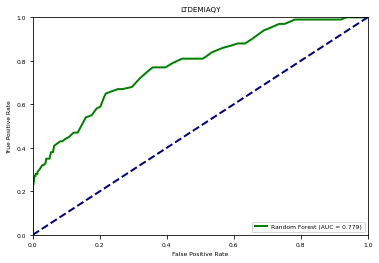

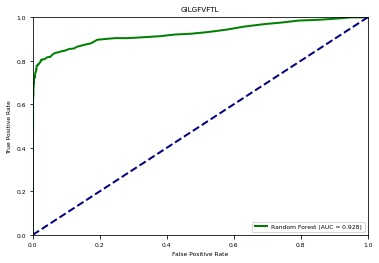

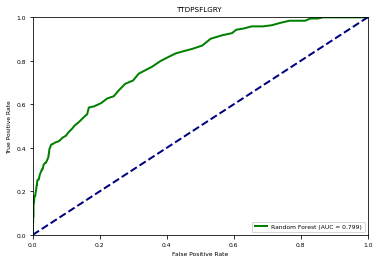

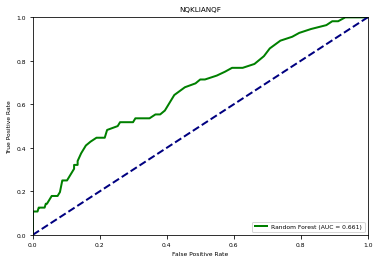

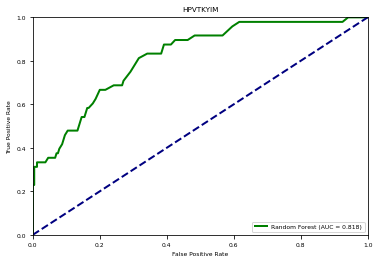

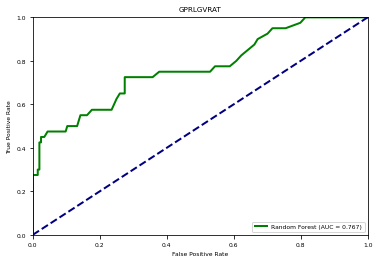

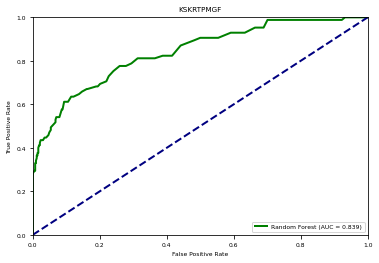

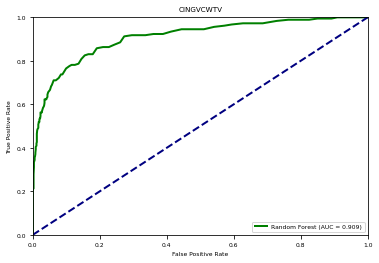

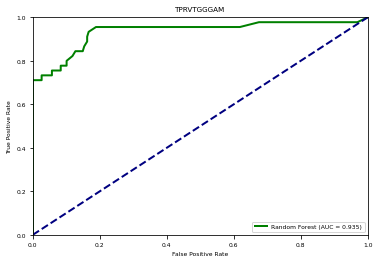

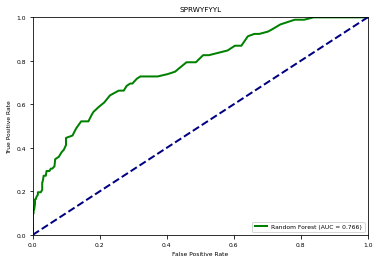

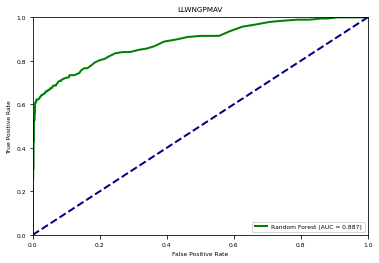

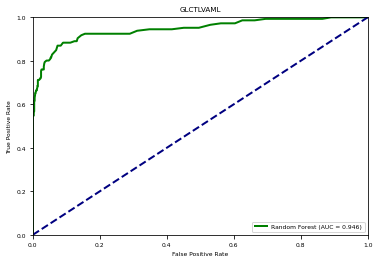

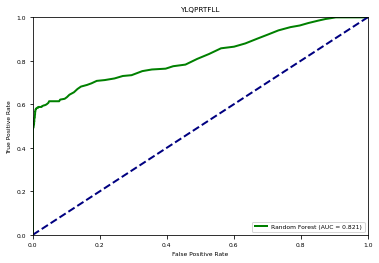

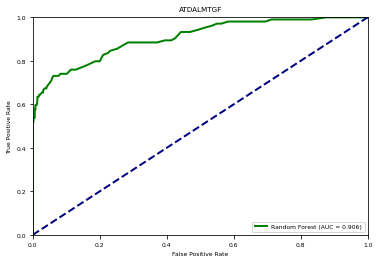

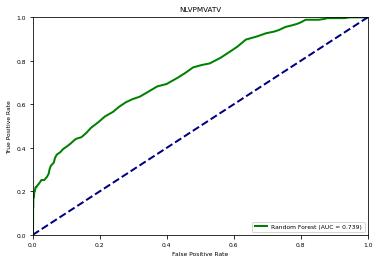

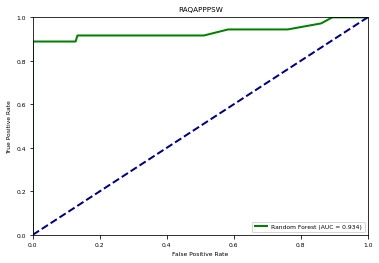

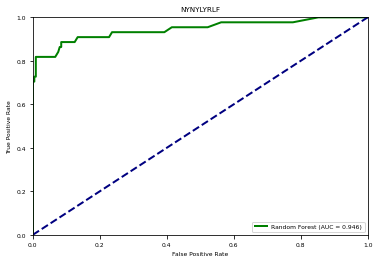

In [9]:
# Alpha-Beta classifier (training and CV)

n_trees = 200

alphabeta_auc = dict()

classifier = dict()
classifier['AB'] = dict()

for epitope in train_list:
    
    X = np.concatenate((alpha_features[epitope].values , beta_features[epitope].values), axis=1)
    
    Y = y[epitope]

    # this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
    classifier['AB'][epitope] = ensemble.RandomForestClassifier(n_trees, random_state=0, class_weight='balanced')
    
    # ROC curve  on the training data 
    predictions_rf = cross_val_predict(classifier['AB'][epitope],X,Y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = metrics.roc_curve(Y,
        predictions_rf[:,1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',
      lw=2, label='Random Forest (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(epitope)
    plt.legend(loc="lower right")
    plt.show()
    
    alphabeta_auc[epitope] = roc_auc
    
    classifier['AB'][epitope].fit(X,Y)


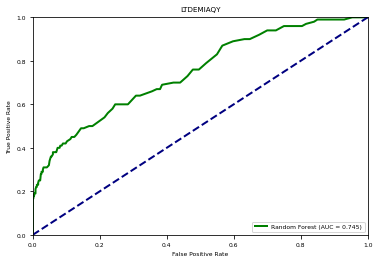

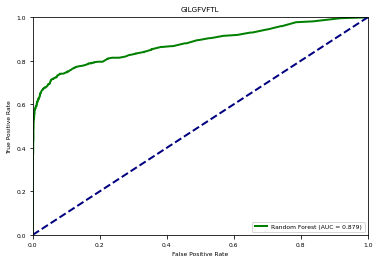

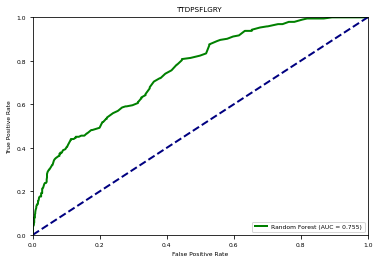

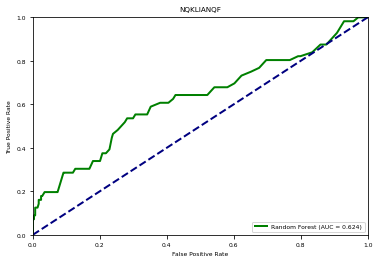

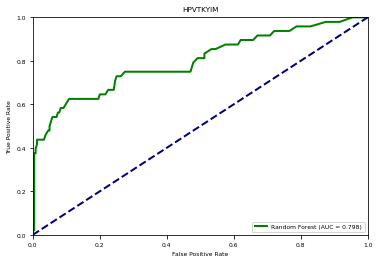

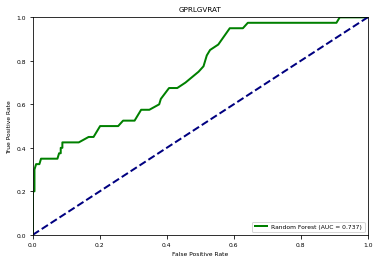

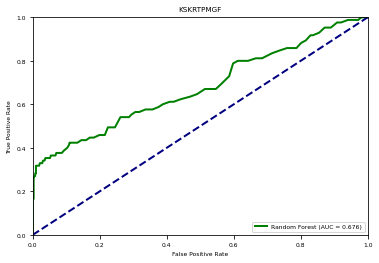

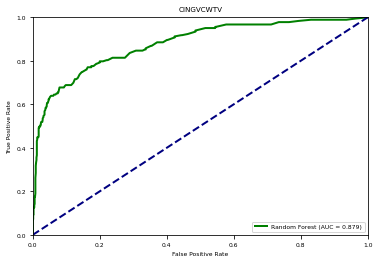

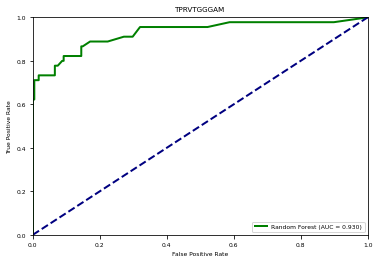

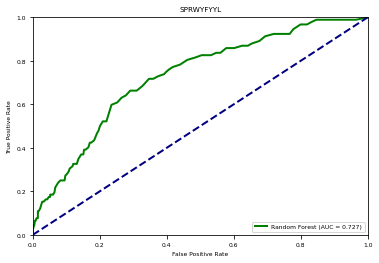

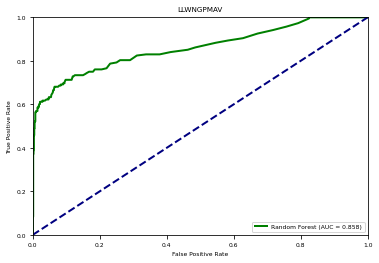

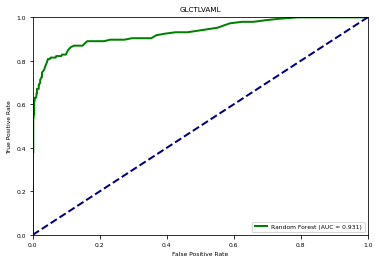

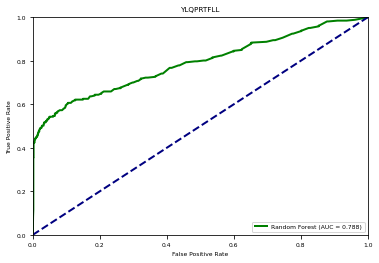

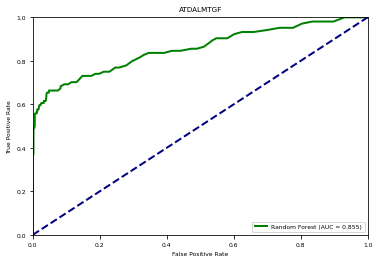

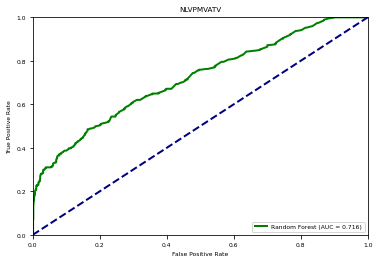

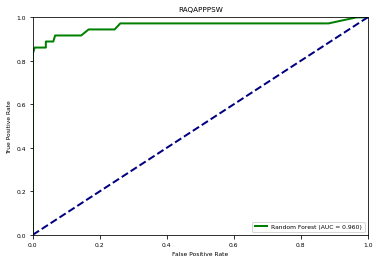

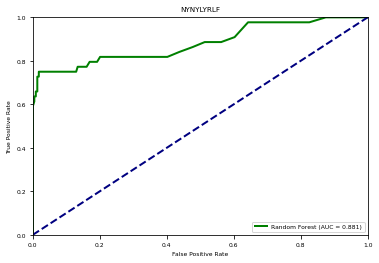

In [10]:
# Alpha classifier (training and CV)

n_trees = 200

alpha_auc = dict()

classifier['A'] = dict()

for epitope in train_list:
    
    X = alpha_features[epitope].values
    
    Y = y[epitope]

    # this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
    classifier['A'][epitope] = ensemble.RandomForestClassifier(n_trees, random_state=0, class_weight='balanced')
    
#    # ROC curve   
    predictions_rf = cross_val_predict(classifier['A'][epitope],X,Y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = metrics.roc_curve(Y,
        predictions_rf[:,1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',
      lw=2, label='Random Forest (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(epitope)
    plt.legend(loc="lower right")
    plt.show()
    
    alpha_auc[epitope] = roc_auc
    
    classifier['A'][epitope].fit(X,Y)

LTDEMIAQY
469


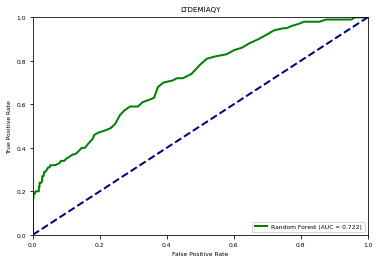

GILGFVFTL
495


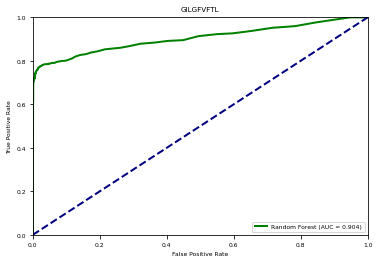

TTDPSFLGRY
474


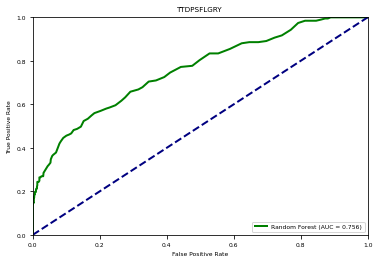

NQKLIANQF
449


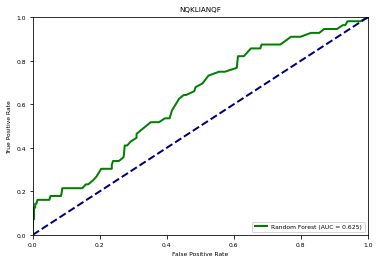

HPVTKYIM
436


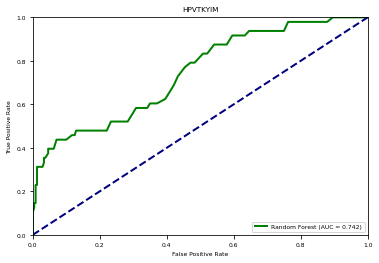

GPRLGVRAT
429


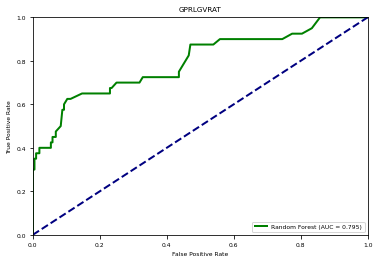

KSKRTPMGF
461


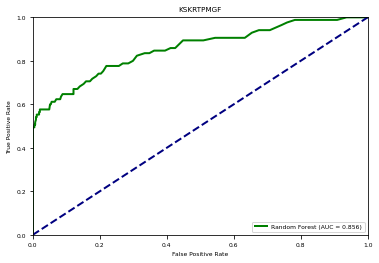

CINGVCWTV
468


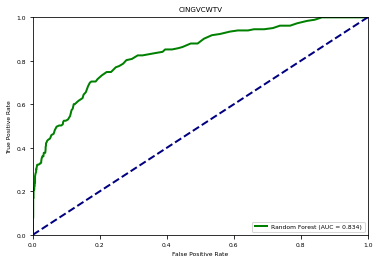

TPRVTGGGAM
438


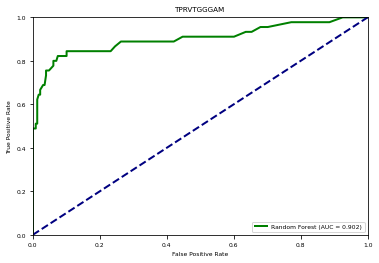

SPRWYFYYL
464


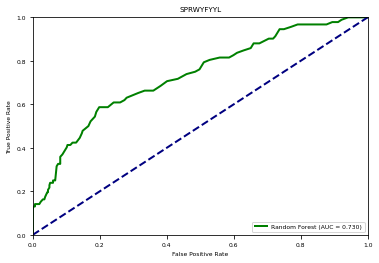

LLWNGPMAV
480


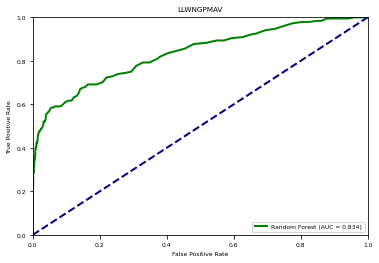

GLCTLVAML
476


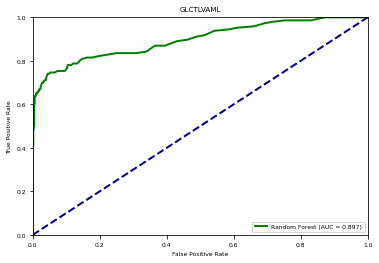

YLQPRTFLL
478


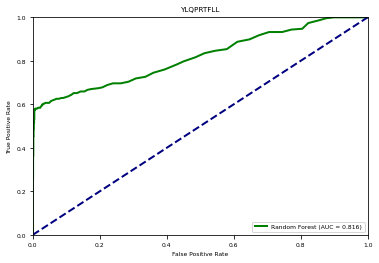

ATDALMTGF
444


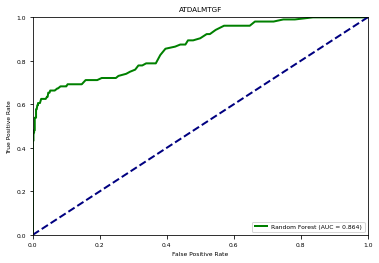

NLVPMVATV
485


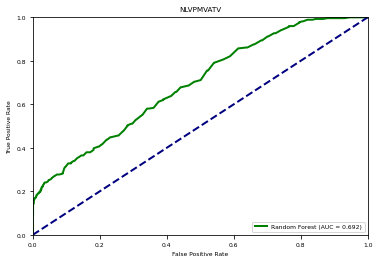

RAQAPPPSW
430


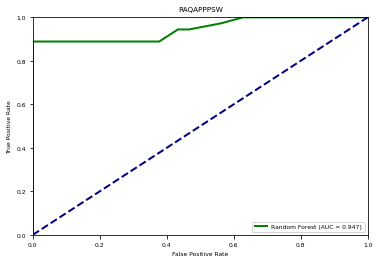

NYNYLYRLF
410


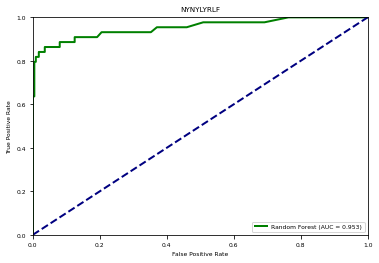

In [11]:
# Beta classifier (training and CV)

n_trees = 200

beta_auc = dict()

classifier['B'] = dict()

for epitope in train_list:
    
    X = beta_features[epitope].values
    
    print(epitope)
    print(str(X.shape[1]))
    
    Y = y[epitope]

    # this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
    classifier['B'][epitope] = ensemble.RandomForestClassifier(n_trees, random_state=0, class_weight='balanced')
    
#    # ROC curve   
    predictions_rf = cross_val_predict(classifier['B'][epitope],X,Y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = metrics.roc_curve(Y,
        predictions_rf[:,1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',
      lw=2, label='Random Forest (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(epitope)
    plt.legend(loc="lower right")
    plt.show()
    
    beta_auc[epitope] = roc_auc
    
    classifier['B'][epitope].fit(X,Y)

# Test data

In [12]:
# read test data
testdir = './IMMREP_2022_TCRSpecificity-main/test_set/'

testfiles = [file for file in os.listdir(testdir) if '.txt' in file]

test_list = dict()

for file in testfiles:
    print(file)
    test_df = pd.read_csv(testdir + file,sep="\t")
    
    test_df = convert_gene_df(test_df)

    epitope = Path(file).stem
    
    test_list[epitope] = test_df

LTDEMIAQY.txt
GILGFVFTL.txt
TTDPSFLGRY.txt
testSet_Global.txt
NQKLIANQF.txt
HPVTKYIM.txt
GPRLGVRAT.txt
KSKRTPMGF.txt
CINGVCWTV.txt
TPRVTGGGAM.txt
SPRWYFYYL.txt
LLWNGPMAV.txt
GLCTLVAML.txt
YLQPRTFLL.txt
ATDALMTGF.txt
NLVPMVATV.txt
RAQAPPPSW.txt
NYNYLYRLF.txt


In [13]:
# compute features for each observation
beta_testfeatures = dict()
alpha_testfeatures = dict()
for peptide in test_list:
    print(peptide)
    print(len(test_list[peptide]))
    beta_testfeatures[peptide] = compute_features(test_list[peptide].rename(columns={'TRBV':'V_gene',
                                                                         'TRBJ':'J_gene',
                                                                         'TRBV_family':'V_family',
                                                                         'TRBJ_family':'J_family',
                                                                         'TRB_CDR3':'CDR3_sequence'})).add_prefix('B_')
    print(len(beta_testfeatures[peptide]))
    alpha_testfeatures[peptide] = compute_features(test_list[peptide].rename(columns={'TRAV':'V_gene',
                                                                         'TRAJ':'J_gene',
                                                                         'TRAV_family':'V_family',
                                                                         'TRAJ_family':'J_family',
                                                                         'TRA_CDR3':'CDR3_sequence'})).add_prefix('A_')

LTDEMIAQY
150
150
GILGFVFTL
812
812
TTDPSFLGRY
291
291
testSet_Global
619
619
NQKLIANQF
86
86
HPVTKYIM
72
72
GPRLGVRAT
62
62
KSKRTPMGF
129
129
CINGVCWTV
275
275
TPRVTGGGAM
69
69
SPRWYFYYL
140
140
LLWNGPMAV
282
282
GLCTLVAML
220
220
YLQPRTFLL
399
399
ATDALMTGF
155
155
NLVPMVATV
411
411
RAQAPPPSW
54
54
NYNYLYRLF
68
68


In [14]:
# Apply the three classifiers to test data

classifiers = ['A','B','AB']

for epitope in test_list:
    if epitope == 'testSet_Global': # Task 2
        
        print(epitope)
        
        for chain in classifiers:
            
            globaldata = []
            
            for peptidemodel in train_list:
                
                print(peptidemodel)
                
                testdata = test_list[epitope].copy(deep=True)
                testdata['epitope'] = peptidemodel
                
                print(len(testdata))
            
                if chain == 'A':
                    
                    print(len(alpha_testfeatures[epitope]))

                    test = add_classifier_features(alpha_testfeatures[epitope],alpha_features[peptidemodel])
                    
                    print(len(test))

                    testdata['score'] = classifier[chain][peptidemodel].predict_proba(test.values)[:,1]

                elif chain == 'B':

                    test = add_classifier_features(beta_testfeatures[epitope],beta_features[peptidemodel])


                    testdata['score'] = classifier[chain][peptidemodel].predict_proba(test.values)[:,1]


                elif chain == 'AB':

                    test = np.concatenate((add_classifier_features(alpha_testfeatures[epitope],alpha_features[peptidemodel]),
                                           add_classifier_features(beta_testfeatures[epitope],beta_features[peptidemodel])), axis=1)

                    testdata['score'] = classifier[chain][peptidemodel].predict_proba(test)[:,1]
                    
                globaldata.append(testdata)
            
            globaldatafull = pd.concat(globaldata)
            globaldatafull.to_csv('./tcrex' + chain + '/' + epitope + '.txt',sep="\t",index=False)
        
    else: # Task 1
        
        print(epitope)
        for chain in classifiers:
            testdata = test_list[epitope].copy(deep=True)
            
            if chain == 'A':
                
                test = add_classifier_features(alpha_testfeatures[epitope],alpha_features[epitope])

                testdata['score'] = classifier[chain][epitope].predict_proba(test.values)[:,1]
                
            elif chain == 'B':
                
                test = add_classifier_features(beta_testfeatures[epitope],beta_features[epitope])

                testdata['score'] = classifier[chain][epitope].predict_proba(test.values)[:,1]
                
                
            elif chain == 'AB':
                
                test = np.concatenate((add_classifier_features(alpha_testfeatures[epitope],alpha_features[epitope]),
                                       add_classifier_features(beta_testfeatures[epitope],beta_features[epitope])), axis=1)
                                      
                testdata['score'] = classifier[chain][epitope].predict_proba(test)[:,1]
            
            testdata.to_csv('./tcrex' + chain + '/' + epitope + '.txt',sep="\t",index=False)

LTDEMIAQY
GILGFVFTL
TTDPSFLGRY
testSet_Global
LTDEMIAQY
619
619
619
GILGFVFTL
619
619
619
TTDPSFLGRY
619
619
619
NQKLIANQF
619
619
619
HPVTKYIM
619
619
619
GPRLGVRAT
619
619
619
KSKRTPMGF
619
619
619
CINGVCWTV
619
619
619
TPRVTGGGAM
619
619
619
SPRWYFYYL
619
619
619
LLWNGPMAV
619
619
619
GLCTLVAML
619
619
619
YLQPRTFLL
619
619
619
ATDALMTGF
619
619
619
NLVPMVATV
619
619
619
RAQAPPPSW
619
619
619
NYNYLYRLF
619
619
619
LTDEMIAQY
619
GILGFVFTL
619
TTDPSFLGRY
619
NQKLIANQF
619
HPVTKYIM
619
GPRLGVRAT
619
KSKRTPMGF
619
CINGVCWTV
619
TPRVTGGGAM
619
SPRWYFYYL
619
LLWNGPMAV
619
GLCTLVAML
619
YLQPRTFLL
619
ATDALMTGF
619
NLVPMVATV
619
RAQAPPPSW
619
NYNYLYRLF
619
LTDEMIAQY
619
GILGFVFTL
619
TTDPSFLGRY
619
NQKLIANQF
619
HPVTKYIM
619
GPRLGVRAT
619
KSKRTPMGF
619
CINGVCWTV
619
TPRVTGGGAM
619
SPRWYFYYL
619
LLWNGPMAV
619
GLCTLVAML
619
YLQPRTFLL
619
ATDALMTGF
619
NLVPMVATV
619
RAQAPPPSW
619
NYNYLYRLF
619
NQKLIANQF
HPVTKYIM
GPRLGVRAT


<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0
<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0


KSKRTPMGF
CINGVCWTV


<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0
<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0
<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature]

TPRVTGGGAM
SPRWYFYYL
LLWNGPMAV


<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0


GLCTLVAML
YLQPRTFLL
ATDALMTGF
NLVPMVATV


<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0


RAQAPPPSW
NYNYLYRLF


<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0
<ipython-input-7-278d25162dae>:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  target[feature] = 0
